In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds

import os
import numpy as np
import matplotlib.pyplot as plt

In [3]:
ds_url = "https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip"
ds_dir = tf.keras.utils.get_file('cats_and_dogs_filtered.zip', origin=ds_url, extract=True)

68606236/68606236 [==============================] - 4s 0us/step


In [4]:
print(ds_dir)

/root/.keras/datasets/cats_and_dogs_filtered.zip


In [5]:
# pathlib.Path(ds_dir)

In [6]:
base_dir = os.path.join(os.path.dirname(ds_dir), 'cats_and_dogs_filtered')
train_dir = os.path.join(base_dir, 'train')
valid_dir = os.path.join(base_dir, 'validation')

In [7]:
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
valid_cats_dir = os.path.join(valid_dir, 'cats')
valid_dogs_dir = os.path.join(valid_dir, 'dogs')

In [8]:
# gets the sample size
num_train_cats = len(os.listdir(train_cats_dir))
num_train_dogs = len(os.listdir(train_dogs_dir))
print('number of cats and dogs are: {} {}'.format(num_train_cats, num_train_dogs))

num_valid_cats = len(os.listdir(valid_cats_dir))
num_valid_dogs = len(os.listdir(valid_dogs_dir))

num_train = num_train_cats + num_train_dogs
num_valid = num_valid_cats + num_valid_dogs

number of cats and dogs are: 1000 1000


In [9]:
BATCH_SIZE = 100
IMG_SHAPE = 150 # images 150 x 150 pixels

In [10]:
def plotImages(images_arr):
  fig, axes = plt.subplots(1, 5, figsize=(20, 20))
  axes = axes.flatten() # might be tuple
  for img, ax in zip(images_arr, axes):
    ax.imshow(img)
  plt.tight_layout()
  plt.show()

In [11]:
train_ds = tf.keras.utils.image_dataset_from_directory(batch_size=BATCH_SIZE,
                                                       directory=train_dir,
                                                       seed=27,
                                                       image_size=(IMG_SHAPE, IMG_SHAPE))

Found 2000 files belonging to 2 classes.


In [12]:
train_ds

<BatchDataset element_spec=(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [13]:
valid_ds = tf.keras.utils.image_dataset_from_directory(batch_size=BATCH_SIZE,
                                                       directory=valid_dir,
                                                       seed=27,
                                                       image_size=(IMG_SHAPE, IMG_SHAPE))

Found 1000 files belonging to 2 classes.


In [14]:
train_ds.class_names

['cats', 'dogs']

In [15]:
for images, labels in train_ds.take(1):
  images = images.numpy() / 255
  labels = labels.numpy()
print(images[0])
print(labels)

[[[0.51830065 0.4112418  0.3054233 ]
  [0.59354645 0.4215379  0.42625687]
  [0.5163399  0.49155337 0.5418518 ]
  ...
  [0.719385   0.6981435  0.6353983 ]
  [0.76682884 0.767417   0.71800536]
  [0.69116867 0.6742405  0.6402567 ]]

 [[0.5447144  0.43550324 0.33918038]
  [0.5902079  0.43704313 0.43551373]
  [0.4959804  0.4781928  0.5203856 ]
  ...
  [0.7512223  0.72998077 0.6672357 ]
  [0.7485509  0.74913913 0.6997274 ]
  [0.6840208  0.6670927  0.62970704]]

 [[0.5409074  0.43209913 0.34954247]
  [0.55289215 0.42877778 0.42319608]
  [0.43908498 0.4365795  0.4616231 ]
  ...
  [0.767255   0.7450329  0.6826147 ]
  [0.7576665  0.7564901  0.7076667 ]
  [0.7124607  0.6901883  0.6539716 ]]

 ...

 [[0.7656429  0.9224981  0.8247202 ]
  [0.6974568  0.85687196 0.7591986 ]
  [0.65969384 0.8225862  0.7355381 ]
  ...
  [0.60996777 0.83741874 0.78111714]
  [0.5684179  0.7993134  0.7551305 ]
  [0.48571214 0.7230325  0.69473195]]

 [[0.72476465 0.8972614  0.78466004]
  [0.6408608  0.81551373 0.7092922 ]


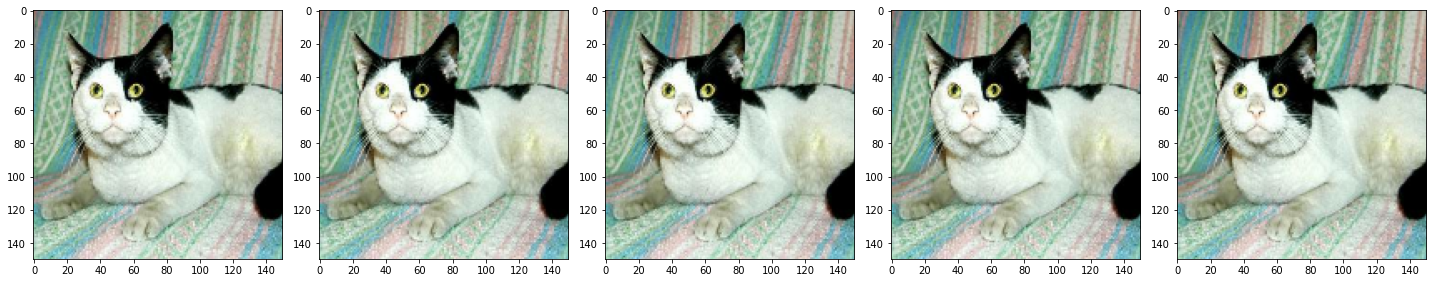

In [16]:
sample_images = [images[0] for i in range(5)]
plotImages(sample_images)

In [17]:
# using keras preprocessing layer for data augmentation and normalization
augment_normalize = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
])

In [21]:
normalize = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255)
])

In [ ]:
images.shape()

In [19]:
images[0].shape

(150, 150, 3)

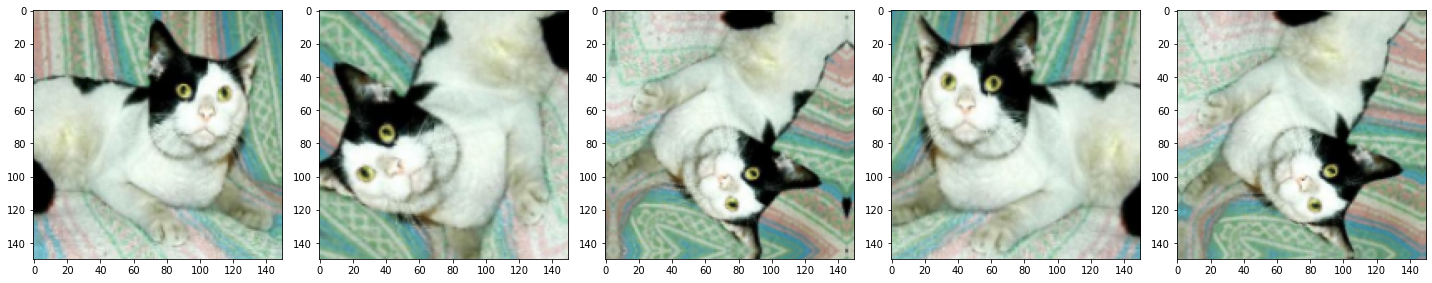

In [20]:
sample_images = [augment_normalize(images[0] * 255) for i in range(5)]
plotImages(sample_images)

In [22]:
model = tf.keras.models.Sequential([
    # add the preproccesing layer
    augment_normalize,

    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(2)
])

In [23]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [24]:
history = model.fit(
    train_ds,
    steps_per_epoch=int(np.ceil(num_train / float(BATCH_SIZE))),
    epochs=100,
    validation_data=valid_ds,
    validation_steps=int(np.ceil(num_valid / float(BATCH_SIZE)))
)

Epoch 1/100


20/20 [==============================] - ETA: 0s - loss: 0.7119 - accuracy: 0.4980

20/20 [==============================] - 18s 256ms/step - loss: 0.7119 - accuracy: 0.4980 - val_loss: 0.7009 - val_accuracy: 0.5000
Epoch 2/100
20/20 [==============================] - 6s 246ms/step - loss: 0.6945 - accuracy: 0.5065 - val_loss: 0.6905 - val_accuracy: 0.5170
Epoch 3/100
20/20 [==============================] - 6s 249ms/step - loss: 0.6916 - accuracy: 0.5150 - val_loss: 0.6843 - val_accuracy: 0.5010
Epoch 4/100
20/20 [==============================] - 6s 248ms/step - loss: 0.6832 - accuracy: 0.5725 - val_loss: 0.6681 - val_accuracy: 0.5420
Epoch 5/100
20/20 [==============================] - 6s 256ms/step - loss: 0.6810 - accuracy: 0.5660 - val_loss: 0.6636 - val_accuracy: 0.5150
Epoch 6/100
20/20 [==============================] - 6s 249ms/step - loss: 0.6614 - accuracy: 0.5980 - val_loss: 0.6409 - val_accuracy: 0.6360
Epoch 7/100
20/20 [==============================] - 6s 250ms/step - loss: 0.6482 - accuracy: 0.6185 - val_loss: 0.6266 - val_accuracy: 0.6360
Epoch 8/10

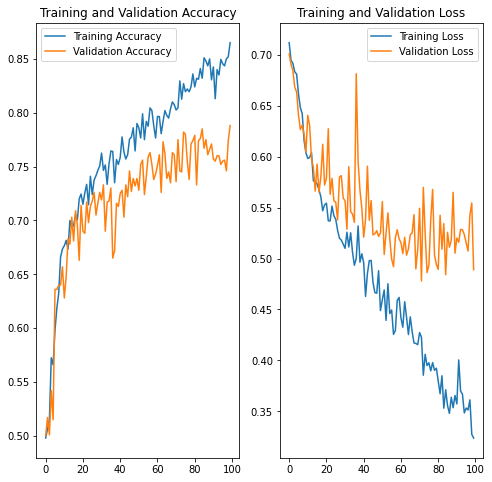

In [27]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(100)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 8))
ax1.plot(epochs_range, train_acc, label='Training Accuracy')
ax1.plot(epochs_range, val_acc, label='Validation Accuracy')
ax1.legend(loc='upper left')
ax1.set_title('Training and Validation Accuracy')

ax2.plot(epochs_range, train_loss, label='Training Loss')
ax2.plot(epochs_range, val_loss, label='Validation Loss')
ax2.legend(loc='upper right')
ax2.set_title('Training and Validation Loss')

plt.show()